In [1]:
import pandas as pd
import pulp as plp
import numpy as np
from sklearn.metrics import accuracy_score

In [241]:
houses = pd.DataFrame(pd.read_csv('E:\sih2019\RWHOptimiser-master\Catchment_area.csv'))
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 3 columns):
Unnamed: 0    1111 non-null int64
x             1111 non-null float64
y             1111 non-null float64
dtypes: float64(2), int64(1)
memory usage: 26.1 KB


In [246]:
houses.head()
seti = range(len(houses))

In [277]:
TOTAL_CATCHMENT_AREA = 31 #Total catchment area in Delhi is close to 31 km^2 which is distributed among our houses
TOTAL_RAINWATER_COLLECTED = 18941 #This is calculated as average annual rainfall * total catchment area and is distributed as demands of houses
import random as ran
r1 = [ran.random() for i in seti]
s1 = sum(r1)
r1 = [ i/s for i in r1 ]
r1 = r1 * TOTAL_CATCHMENT_AREA
houses['catch_area_km_sq'] = pd.Series(r1)
r2 = [ran.random() for i in seti]
s2 = sum(r2)
r2 = [ i/s2 for i in r2 ]
r2 = r2 * TOTAL_RAINWATER_COLLECTED
houses['catch_area_km_sq'] = pd.Series(r1)
houses['demand_in_litres'] = pd.Series(r2)


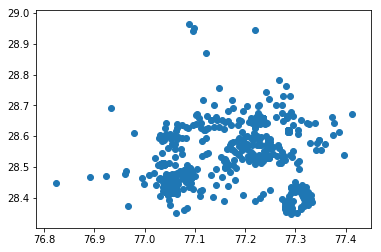

In [278]:
# import seaborn as sns
# sns.scatterplot(data = houses[:1000])

import matplotlib.pyplot as plt
plt.scatter(x = houses['x'], y = houses['y'])
plt.show()

In [279]:
from sklearn.cluster import KMeans


In [280]:
kmeans = KMeans(n_clusters= 15)

In [281]:
someData=[] 
for x,y in zip(houses['x'].values, houses['y'].values):
    someData.append([x,y])
    

In [282]:
# kmeans.fit(houses['house_data_x'].values.reshape(-1, 1), y = houses['house_data_y'].values.reshape(-1, 1))
# print(houses[:,1])
# print(houses[:,2])
# arr = []
# for i in range(1111):
#     arr.append([houses[:,1][i], houses[:,2][i]])
#print(arr)
# kmeans.fit(arr)
clusters = kmeans.fit_predict(someData)

In [283]:
# clusters =kmeans.predict(houses['house_data_x'].values.reshape(-1, 1), houses['house_data_y'].values.reshape(-1, 1))

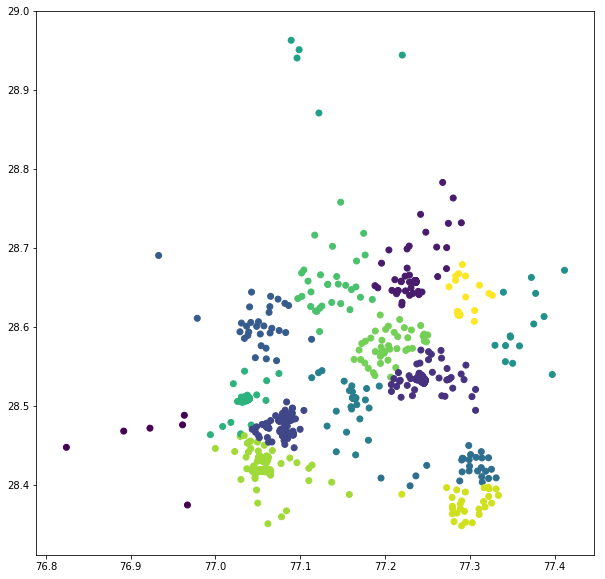

In [284]:
plt.figure(figsize = (10,10))

#plt.scatter(houses[:,1], houses[:,2], c = clusters)
plt.scatter(houses['x'], houses['y'], c = clusters)

In [285]:
centers = np.array(kmeans.cluster_centers_)

tanks = pd.DataFrame({'x' : centers[:, 0], 'y' : centers[:, 1]})

In [286]:
tanks['stability'] = np.random.normal(0.5, 0.2, len(tanks)) #assigning random values of stability to all tank locations
tanks

,x,y,stability
0,76.921653,28.454141,0.496142
1,77.234852,28.663688,0.787468
2,77.246160,28.533785,0.378485
3,77.078970,28.475475,0.230470
4,77.051057,28.603416,0.675096
5,77.294978,28.421969,0.625832
6,77.162116,28.507787,0.418619
7,77.362972,28.599323,0.548349
8,77.125333,28.934039,0.677260
9,77.035650,28.507796,0.698845


In [287]:
import math
PIPE_COST_PER_METRE = 300 
seti = range(len(houses))
setj = range(len(tanks))
COST = [[] for i in range(len(tanks))]
def distance(j, i):
    a= (houses.loc[i, 'x'] - tanks.loc[j, 'x']) ** 2 
    b= (houses.loc[i, 'y'] - tanks.loc[j, 'y']) ** 2
    #Proper conversion function needs to be found to convert lat, long distance to metres
    return math.sqrt(a+b)

for j in setj:
    for i in seti:
        COST[j].append(distance(j, i) * PIPE_COST_PER_METRE) 
len(COST)

15

In [325]:
import pulp
M = len(houses)
FIXED_CONST_COST_UNIT_VOL = 4
SUPPLY = []

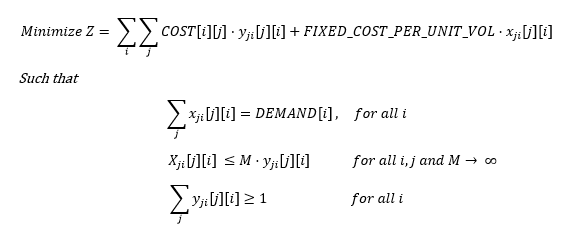

In [292]:
#SUPPLY ORIENTED APPROACH
lp_prob0 = pulp.LpProblem("LP0", pulp.LpMinimize)

# pipe from jth tank to ith house
yji = {
    (j, i): plp.LpVariable(
        cat = plp.LpBinary,
        name = "y_{0}_{1}".format(j,i)
    ) for j in setj for i in seti
}
# # Volume of water transported from jth tank to ith house
xji = {
    (j, i): plp.LpVariable(
        cat = plp.LpContinuous,
        lowBound = 0,
        upBound = None, # no upper bound
        name = "x_{0}_{1}".format(j, i)
    ) for j in setj for i in seti
}

# setting up the constraints

constraint_1 = {
    i : plp.LpConstraint(
        e = plp.lpSum(xji[j,i] for j in setj),
        sense = plp.LpConstraintEQ,
        rhs = houses['demand_in_litres'][i]
    ) for i in seti
}

constraint_2 = {
    (j,i) : plp.LpConstraint(
        e = xji[j,i],
        sense = plp.LpConstraintLE,
        rhs = M * yji[j,i]
    ) for j in setj for i in seti
}

constraint_3 = {
    i : plp.LpConstraint(
        e = plp.lpSum(yji[j,i] for j in setj),
        sense = plp.LpConstraintGE,
        rhs = 1
    ) for i in seti
}


In [319]:
objective = plp.lpSum(COST[j][i] * yji[j, i] + FIXED_CONST_COST_UNIT_VOL * xji[j, i] for i in seti for j in setj)

In [320]:
lp_prob0.setObjective(objective)
for i in seti:
    lp_prob0 += constraint_1[i]
for j in setj:
    lp_prob0 += constraint_2[j]

In [321]:
P0 = [0] * len(tanks)
status0 = lp_prob0.solve()
print(plp.LpStatus[lp_prob0.status])
if status0 == 1:
    for j in setj:
        SUPPLY[j] = 0
        for i in seti:
            SUPPLY[j] += xji[j,i]
            P0[j] = max(P0[j], yji[j,i])

Infeasible


In [299]:
lp_prob0

LP0:
MINIMIZE
4*x_0_0 + 4*x_0_1 + 4*x_0_10 + 4*x_0_100 + 4*x_0_1000 + 4*x_0_1001 + 4*x_0_1002 + 4*x_0_1003 + 4*x_0_1004 + 4*x_0_1005 + 4*x_0_1006 + 4*x_0_1007 + 4*x_0_1008 + 4*x_0_1009 + 4*x_0_101 + 4*x_0_1010 + 4*x_0_1011 + 4*x_0_1012 + 4*x_0_1013 + 4*x_0_1014 + 4*x_0_1015 + 4*x_0_1016 + 4*x_0_1017 + 4*x_0_1018 + 4*x_0_1019 + 4*x_0_102 + 4*x_0_1020 + 4*x_0_1021 + 4*x_0_1022 + 4*x_0_1023 + 4*x_0_1024 + 4*x_0_1025 + 4*x_0_1026 + 4*x_0_1027 + 4*x_0_1028 + 4*x_0_1029 + 4*x_0_103 + 4*x_0_1030 + 4*x_0_1031 + 4*x_0_1032 + 4*x_0_1033 + 4*x_0_1034 + 4*x_0_1035 + 4*x_0_1036 + 4*x_0_1037 + 4*x_0_1038 + 4*x_0_1039 + 4*x_0_104 + 4*x_0_1040 + 4*x_0_1041 + 4*x_0_1042 + 4*x_0_1043 + 4*x_0_1044 + 4*x_0_1045 + 4*x_0_1046 + 4*x_0_1047 + 4*x_0_1048 + 4*x_0_1049 + 4*x_0_105 + 4*x_0_1050 + 4*x_0_1051 + 4*x_0_1052 + 4*x_0_1053 + 4*x_0_1054 + 4*x_0_1055 + 4*x_0_1056 + 4*x_0_1057 + 4*x_0_1058 + 4*x_0_1059 + 4*x_0_106 + 4*x_0_1060 + 4*x_0_1061 + 4*x_0_1062 + 4*x_0_1063 + 4*x_0_1064 + 4*x_0_1065 + 4*x_0_1066 + 

In [235]:
#DEMAND ORIENTED APPROACH
lp_prob = pulp.LpProblem("LP1", pulp.LpMinimize)
# pipe from ith house to jth tank
yij = {
    (i, j): plp.LpVariable(
        cat = plp.LpBinary,
        name = "y_{0}_{1}".format(i,j)
    ) for i in seti for j in setj
}
# # Volume of water transported from ith house to jth tank
xij = {
    (i, j): plp.LpVariable(
        cat = plp.LpContinuous,
        lowBound = 0,
        upBound = None, # no upper bound
        name = "x_{0}_{1}".format(i,j)
    ) for i in seti for j in setj
}
# setting up the constraints

constraint_1 = {
    j : plp.LpConstraint(
        e = plp.lpSum(xij[i,j] for i in seti),
        sense = plp.LpConstraintLE,
        rhs = SUPPLY[j]
    ) for j in setj
}

constraint_2 = {
    i : plp.LpConstraint(
        e = plp.lpSum(xij[i,j] for j in setj),
        sense = plp.LpConstraintEQ,
        rhs = RAIN * houses['area_per_house_metersq'][i]
    ) for i in seti
}

constraint_3 = {
    (i,j) : plp.LpConstraint(
        e = xij[i,j],
        sense = plp.LpConstraintLE,
        rhs = M * yij[i, j]
    ) for i in seti for j in setj
}

IndexError: list index out of range

In [136]:
objective = plp.lpSum(COST[j][i] * yij[i,j] for i in seti for j in setj)

In [137]:
lp_prob.setObjective(objective)
for j in setj:
    lp_prob += constraint_1[j]
for i in seti:
    lp_prob += constraint_2[i]
for i in seti:
    for j in setj:
        lp_prob += constraint_3[i, j]

KeyError: 0

In [142]:
P = [0] * NUMBER_TANKS
status = lp_prob.solve()
if status == 1:
    for j in setj:
        for i in seti:
            P[j] = max(P[j], yij[i,j])

TypeError: '>' not supported between instances of 'LpVariable' and 'int'

In [ ]:
accuracy_score(np.array(P0), np.array(P))